Project work part II

Motivated by the sequential methods we discussed in class, our goal here is to design (7
points) and implement (7 points) a new method for producing sequential group
recommendations. Also, provide detailed explanations and clarifications about why the
method you propose works well for the case of sequential group recommendations (6
points). Prepare also a short presentation (about 5 slides) to show how your method
works (5 points). 

In [2]:

import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [3]:
links = pd.read_csv('ml-latest-small/links.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')

print("Links Dataset:")
display(links.head())

print("\nMovies Dataset:")
display(movies.head())

print("\nRatings Dataset:")
display(ratings.head())

print("\nTags Dataset:")
display(tags.head())

rating_count = ratings.shape[0]
print(f"\nTotal number of ratings: {rating_count}")

Links Dataset:


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0



Movies Dataset:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



Ratings Dataset:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931



Tags Dataset:


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200



Total number of ratings: 100836



Iteration 1:
User 45 recommendations: ['Shawshank Redemption, The (1994)', "Schindler's List (1993)", 'Seven (a.k.a. Se7en) (1995)', 'Lord of the Rings: The Return of the King, The (2003)', 'Fargo (1996)']
User 11 recommendations: ['Pulp Fiction (1994)', 'Matrix, The (1999)', "Schindler's List (1993)", 'Star Wars: Episode IV - A New Hope (1977)', 'Seven (a.k.a. Se7en) (1995)']
User 7 recommendations: ['Shawshank Redemption, The (1994)', 'Matrix, The (1999)', 'Pulp Fiction (1994)', 'Fight Club (1999)', 'Braveheart (1995)']
User 33 recommendations: ['Star Wars: Episode IV - A New Hope (1977)', 'Jurassic Park (1993)', 'Seven (a.k.a. Se7en) (1995)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Fight Club (1999)']
User 28 recommendations: ['Toy Story (1995)', 'Back to the Future (1985)', 'Shrek (2001)', 'Apollo 13 (1995)', 'Indiana Jones and the Last Crusade (1989)']
Group recommendations: ['Shawshank Redemption, The (1994)', 'Seven (a.k.a. Se7en) (1995)', 'Pulp Fiction (1994)

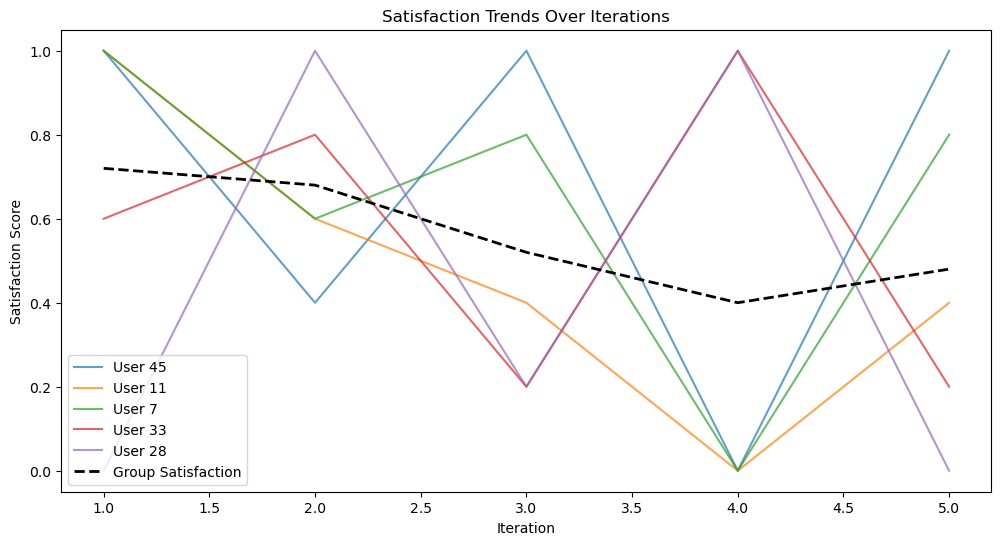

In [ ]:
# User-item matrix for cosine similarity
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

similarity_matrix = cosine_similarity(user_item_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

group_users = [1, 2, 3, 4, 5]

# Satisfaction scores for the users (initially all unsatisfied)
satisfaction_scores = {user: 0.0 for user in group_users}

# Keep track of movies already recommended for each user and group
user_history = {user: set() for user in group_users}
group_history = set()

# Keep track of satisfaction trends
satisfaction_trends = {user: [] for user in group_users}

# Function to get movie names
def get_movie_title(movie_id):
    title = movies[movies['movieId'] == movie_id]['title']
    return title.values[0] if not title.empty else "Unknown"

# Function to apply fairness-aware weights
def capped_weights(weights, cap=2.0):
    return {user: min(weight, cap) for user, weight in weights.items()}

# Function to recommend for a user based on similarity
def recommend_for_user(user_id, user_item_matrix, similarity_df, num_recommendations=5):
    similar_users = similarity_df[user_id].sort_values(ascending=False)
    user_rated_movies = user_item_matrix.loc[user_id]
    watched_movies = set(user_rated_movies[user_rated_movies > 0].index)
    scores = pd.Series(dtype=np.float64)
    
    for similar_user, similarity_score in similar_users.items():
        if similar_user == user_id:
            continue
        weighted_ratings = user_item_matrix.loc[similar_user] * similarity_score
        scores = scores.add(weighted_ratings, fill_value=0)
    
    scores = scores[~scores.index.isin(watched_movies | user_history[user_id] | group_history)]

    # Genre-matching adjustment
    user_ratings = ratings[ratings['userId'] == user_id]
    high_rated_movies = user_ratings[user_ratings['rating'] >= 4.0]['movieId']
    high_rated_genres = movies[movies['movieId'].isin(high_rated_movies)]['genres']
    user_genres = set([genre for genres in high_rated_genres for genre in genres.split('|')])
    
    for movie_id in scores.index:
        movie_genres = set(movies[movies['movieId'] == movie_id]['genres'].values[0].split('|'))
        genre_match = len(user_genres & movie_genres)
        scores[movie_id] += genre_match * 0.1

    recommended_movies = scores.sort_values(ascending=False).head(num_recommendations)
    user_history[user_id].update(recommended_movies.index)
    return [(movie_id, score) for movie_id, score in recommended_movies.items()]

# Aggregation with fairness
def aggregate_group_recommendations(user_recommendations, weights, max_recommendations=10):
    weights = capped_weights(weights, cap=2.0)  # Apply fairness cap
    scores = defaultdict(float)
    for user, recommendations in user_recommendations.items():
        weight = weights[user]
        for movie_id, score in recommendations:
            scores[movie_id] += score * weight
    
    scores = {movie: score for movie, score in scores.items() if movie not in group_history}
    sorted_recommendations = sorted(scores.items(), key=lambda x: -x[1])
    top_recommendations = [movie for movie, _ in sorted_recommendations[:max_recommendations]]
    group_history.update(top_recommendations)
    return top_recommendations

# Simulation over iterations
group_satisfaction_trend = []
num_iterations = 5
for iteration in range(1, num_iterations + 1):
    print(f"\nIteration {iteration}:")
    
    user_recommendations = {}
    for user in group_users:
        user_recommendations[user] = recommend_for_user(user, user_item_matrix, similarity_df)
        movie_titles = [get_movie_title(movie_id) for movie_id, _ in user_recommendations[user]]
        print(f"User {user} recommendations: {movie_titles}")
    
    weights = {user: 1.0 + (1.0 - satisfaction_scores[user]) for user in group_users}
    group_recommendations = aggregate_group_recommendations(user_recommendations, weights)
    group_movie_titles = [get_movie_title(movie_id) for movie_id in group_recommendations]
    print(f"Group recommendations: {group_movie_titles}")
    
    iteration_satisfaction = []
    for user in group_users:
        matched_recommendations = set([movie_id for movie_id, _ in user_recommendations[user]]) & set(group_recommendations)
        total_recommendations = len(user_recommendations[user])
        satisfaction_scores[user] = len(matched_recommendations) / total_recommendations  # Continuous satisfaction score
        satisfaction_trends[user].append(satisfaction_scores[user])
        iteration_satisfaction.append(satisfaction_scores[user])
    print(f"Satisfaction scores: {satisfaction_scores}")

    group_satisfaction = np.mean(iteration_satisfaction)
    group_satisfaction_trend.append(group_satisfaction)

plt.figure(figsize=(12, 6))

# Individual satisfaction trends
for user, scores in satisfaction_trends.items():
    plt.plot(range(1, num_iterations + 1), scores, label=f'User {user}', alpha=0.7)

# Group satisfaction trend
plt.plot(range(1, num_iterations + 1), group_satisfaction_trend, label='Group Satisfaction', color='black', linewidth=2, linestyle='--')

plt.title("Satisfaction Trends Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Satisfaction Score")
plt.legend()
plt.show()


In [14]:
group_users = [3, 4, 1, 33, 21]

# Satisfaction scores for the users (initially all unsatisfied)
satisfaction_scores = {user: 0.0 for user in group_users}

# Keep track of movies already recommended for each user
user_history = {user: set() for user in group_users}

# Function to recommend items to a single user based on their ratings
def recommend_for_user(user_id, num_recommendations=5):
    # Get movies rated highly by the user
    user_ratings = ratings[ratings['userId'] == user_id]
    high_rated_movies = user_ratings[user_ratings['rating'] >= 4.0]
    
    # Get genres of highly-rated movies
    high_rated_movie_ids = high_rated_movies['movieId'].unique()
    high_rated_genres = movies[movies['movieId'].isin(high_rated_movie_ids)]['genres']
    genre_set = set([genre for genres in high_rated_genres for genre in genres])
    
    # Recommend movies with similar genres not yet rated or recommended by the user
    candidate_movies = movies[~movies['movieId'].isin(user_ratings['movieId'])]
    candidate_movies = candidate_movies.copy()  # Avoid SettingWithCopyWarning
    candidate_movies['genre_match'] = candidate_movies['genres'].apply(lambda x: len(set(x) & genre_set))
    
    # Exclude already recommended movies
    already_recommended = user_history[user_id]
    candidate_movies = candidate_movies[~candidate_movies['movieId'].isin(already_recommended)]
    
    # Sort by genre match and select top recommendations
    recommended_movies = candidate_movies.sort_values(by='genre_match', ascending=False).head(num_recommendations)
    recommended_movie_ids = recommended_movies['movieId'].tolist()
    
    # Update user history
    user_history[user_id].update(recommended_movie_ids)
    
    return recommended_movie_ids

# Function to aggregate individual recommendations into group recommendations
def aggregate_group_recommendations(user_recommendations, weights):
    recommendation_scores = defaultdict(float)
    for user, recommendations in user_recommendations.items():
        weight = weights[user]
        for movie_id in recommendations:
            recommendation_scores[movie_id] += weight # / (rank +1)
    # Sort movies by aggregated score
    sorted_recommendations = sorted(recommendation_scores.items(), key=lambda x: -x[1])
    return [movie[0] for movie in sorted_recommendations]

# Function to det movies' names
def get_movie_title(movie_id):
    title = movies[movies['movieId'] == movie_id]['title']
    return title.values[0] if not title.empty else "Unknown"

# Function to simulate multiple iterations with dynamic recommendations
num_iterations = 5
for iteration in range(1, num_iterations + 1):
    print(f"\nIteration {iteration}:")
    
    # Single user recommendations
    user_recommendations = {}
    for user in group_users:
        user_recommendations[user] = recommend_for_user(user)
        movie_titles = [get_movie_title(movie_id) for movie_id in user_recommendations[user]]
        print(f"User {user} recommendations: {movie_titles}")
    
    # Calculate weights for group aggregation
    weights = {user: 1.0 + (1.0 - satisfaction_scores[user]) for user in group_users}
    
    # Group recommendations
    group_recommendations = aggregate_group_recommendations(user_recommendations, weights)
    group_recommendations = group_recommendations[:5]
    group_movie_titles = [get_movie_title(movie_id) for movie_id in group_recommendations]
    print(f"Group recommendations: {group_movie_titles}")
    
    # Evaluate satisfaction scores
    for user in group_users:
        # Check how many of the user's recommendations are in the group recommendations
        matched_recommendations = set(user_recommendations[user]) & set(group_recommendations)
        if len(matched_recommendations) >= 3:  # At least 3 recommendations in group recommendations
            satisfaction_scores[user] = min(1.0, satisfaction_scores[user] + 0.5)  # Increase satisfaction
        else:
            satisfaction_scores[user] = max(0.0, satisfaction_scores[user] - 0.5)  # Decrease satisfaction
    
    # Print satisfaction scores
    print(f"Satisfaction scores: {satisfaction_scores}")


Iteration 1:
User 3 recommendations: ['Interstate 60 (2002)', 'Rubber (2010)', 'Robots (2005)', 'Wizards of Waverly Place: The Movie (2009)', 'Maximum Ride (2016)']
User 4 recommendations: ['Rubber (2010)', 'Interstate 60 (2002)', 'Aelita: The Queen of Mars (Aelita) (1924)', 'Wizards of Waverly Place: The Movie (2009)', 'Patlabor: The Movie (Kidô keisatsu patorebâ: The Movie) (1989)']
User 1 recommendations: ['Rubber (2010)', 'Interstate 60 (2002)', 'Aelita: The Queen of Mars (Aelita) (1924)', 'Patlabor: The Movie (Kidô keisatsu patorebâ: The Movie) (1989)', 'Robots (2005)']
User 33 recommendations: ['Rubber (2010)', 'Interstate 60 (2002)', 'Aelita: The Queen of Mars (Aelita) (1924)', 'Robots (2005)', 'Maximum Ride (2016)']
User 21 recommendations: ['Rubber (2010)', 'Robots (2005)', 'Interstate 60 (2002)', 'Aelita: The Queen of Mars (Aelita) (1924)', 'Mars Needs Moms (2011)']
Group recommendations: ['Interstate 60 (2002)', 'Rubber (2010)', 'Robots (2005)', 'Aelita: The Queen of Mars (

Tässä vasta pohdintaan, vaihdetaan näitä sitten englanniksi jos päädytään tähän ratkaisuun. 

Valitsemme yksinkertaisen Markovin ketjuihin perustuvan menetelmän, joka ottaa huomioon ryhmän katseluhistorian ja soveltaa sitä sekventiaalisiin suosituksiin. Lisäksi yhdistämme siihen ryhmäkohtaista aggregointia, joka mukautuu ryhmän mieltymysten mukaan.

Menetelmän ydin:
Siirtymätodennäköisyydet:

Lasketaan siirtymätodennäköisyydet genrejen välillä käyttäen käyttäjäkohtaisia katseluhistorioita. Näitä siirtymiä käytetään ennustamaan seuraavia genrejä.
Ryhmäaggregointi:

Käytetään keskiarvomenetelmää: Yhdistetään yksittäisten käyttäjien suositukset keskiarvoistamalla genren siirtymätodennäköisyydet.
Käytetään myös vähimmän tyytyväisyyden menetelmää (least misery): Suositellaan vain genrejä, jotka kaikki ryhmän jäsenet hyväksyisivät. Tämä toimii kompromissiratkaisuna.
Sekventiaalisuuden huomioiminen:

Käytetään viimeisintä katsottua genreä tai viimeisimpiä genrejä ennustamaan ryhmän seuraavaa valintaa. Näin menetelmä mukautuu ajan mukana ryhmän tottumuksiin.


In [3]:
import pandas as pd
import numpy as np
from collections import defaultdict


# Erotellaan genre ensimmäisenä olevaksi genrekentäksi (jos genret eroteltu "|"-merkeillä)
movies['primary_genre'] = movies['genres'].apply(lambda x: x.split('|')[0] if isinstance(x, str) else None)

# Yhdistetään datasetit movieId:n perusteella
data = pd.merge(ratings, movies[['movieId', 'primary_genre']], on='movieId')

# Tarkastetaan yhdistetty data
print(data.head())

# Nyt jokaisella rivillä on userId, movieId, rating, timestamp ja primary_genre

# Lasketaan genre-siirtymät käyttäjäkohtaisesti
transition_counts = defaultdict(lambda: defaultdict(int))

# Käydään läpi käyttäjäkohtaiset genret aikajärjestyksessä
users = data['userId'].unique()
for user in users:
    user_data = data[data['userId'] == user].sort_values(by="timestamp")
    genres = user_data['primary_genre'].tolist()
    for i in range(len(genres) - 1):
        current_genre = genres[i]
        next_genre = genres[i + 1]
        transition_counts[current_genre][next_genre] += 1

# Muutetaan siirtymätodennäköisyyksiksi
transition_probabilities = {}
for genre, transitions in transition_counts.items():
    total_transitions = sum(transitions.values())
    transition_probabilities[genre] = {next_genre: count / total_transitions for next_genre, count in transitions.items()}

# Tulostetaan siirtymätodennäköisyydet
print("Transition probabilities:")
for genre, probs in transition_probabilities.items():
    print(f"{genre}: {probs}")

# Suositustoiminto: suosittele seuraava genre
def recommend_next_genre(current_genre):
    next_genre_probs = transition_probabilities.get(current_genre, {})
    if not next_genre_probs:
        return np.random.choice(list(transition_probabilities.keys()))  # Palauta satunnainen genre, jos ei ole siirtymätietoa
    genres = list(next_genre_probs.keys())
    probs = list(next_genre_probs.values())
    return np.random.choice(genres, p=probs)

# Testataan suositusta
current_genre = "Comedy"
next_genre = recommend_next_genre(current_genre)
print(f"Next recommended genre after {current_genre}: {next_genre}")


   userId  movieId  rating  timestamp primary_genre
0       1        1     4.0  964982703     Adventure
1       1        3     4.0  964981247        Comedy
2       1        6     4.0  964982224        Action
3       1       47     5.0  964983815       Mystery
4       1       50     5.0  964982931         Crime
Transition probabilities:
Action: {'Comedy': 0.18136772330511255, 'Action': 0.4380127321651244, 'Drama': 0.13057032224191115, 'Children': 0.014930760648421606, 'Adventure': 0.10645140119446085, 'Horror': 0.02077180547351841, 'Thriller': 0.0064645271378880355, 'Animation': 0.019360766555096148, 'Crime': 0.055522740696987594, 'Documentary': 0.00534882194657741, 'Sci-Fi': 0.0038721533110192296, 'Western': 0.0010500754741747064, 'Mystery': 0.010467939883179104, 'Film-Noir': 0.000459408019951434, 'Musical': 0.0009844457570387872, 'Romance': 0.0008531863227669488, '(no genres listed)': 0.0004265931613834744, 'War': 0.00016407429283979785, 'Fantasy': 0.0029205224125484017}
Comedy: {'Ani

Miksi tämä menetelmä toimii?
Sekventiaalisuuden huomioiminen:

Markovin ketjut ottavat suoraan huomioon ryhmän aiemmat valinnat ja niiden väliset siirtymät, mikä tekee suosituksista mukautuvia.
Sekventiaalisuus mahdollistaa ryhmän mieltymysten dynaamisen seuraamisen ajan myötä.
Ryhmäaggregoinnin käyttö:

Keskiarvomenetelmä varmistaa, että kaikkien ryhmän jäsenten mieltymykset huomioidaan tasapuolisesti.
Vähimmän tyytyväisyyden menetelmä varmistaa, että suositukset eivät jätä yksittäistä ryhmän jäsentä täysin tyytymättömäksi.
Helppo toteuttaa ja laajentaa:

Markovin ketjut ovat suoraviivaisia ja laskettavissa ilman raskasta laskentaa.
Menetelmää voidaan laajentaa helposti lisäämällä esimerkiksi ajallisia painotuksia, kuten antamalla enemmän merkitystä tuoreimmille valinnoille.
